In [22]:
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import wandb
import opendatasets as od
from pathlib import Path
from collections import Counter
import splitfolders
from sklearn.metrics import precision_score,recall_score

In [23]:
trans=transforms.Compose([transforms.Resize((224,224)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                         
                         ])

In [24]:
train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)
train_dataset.classes

['Cyst', 'Normal', 'Stone', 'Tumor']

In [25]:
classifier = torchvision.models.vgg19(pretrained=True)

#classifier.linear_layers = nn.Linear(1000, 1)

C:\Users\haeun\anaconda3\envs\spring24\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\haeun\anaconda3\envs\spring24\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
classifier.classifier[6]=nn.Linear(4096,4)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Text(0.5, 1.0, '                Cyst,                  Cyst,                Normal,                Normal,                Normal,                 Stone,                Normal,                  Cyst,                 Tumor,                  Cyst,                Normal,                Normal,                 Tumor,                Normal,                 Tumor,                  Cyst,                  Cyst,                  Cyst,                 Tumor,                 Tumor,                 Stone,                 Tumor,                  Cyst,                 Tumor,                  Cyst,                Normal,                  Cyst,                 Tumor,                  Cyst,                  Cyst,                 Tumor,                Normal, ')

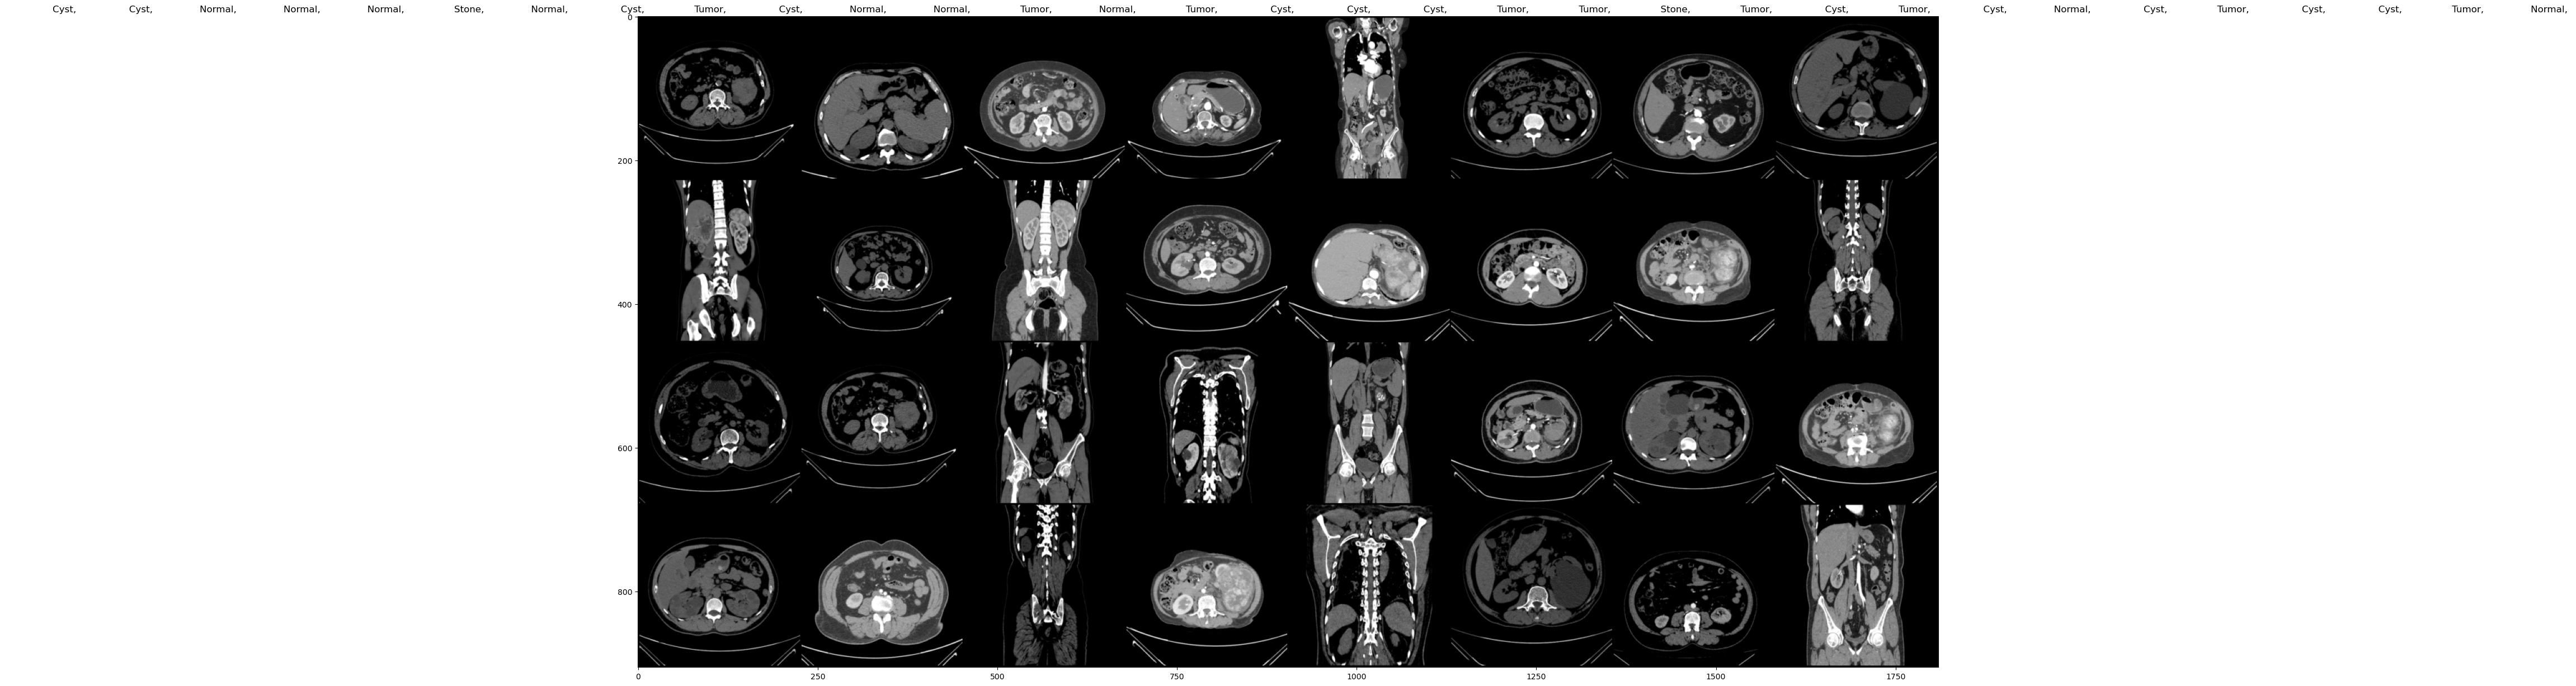

In [27]:
classes=(train_dataset.classes)
train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
fig = plt.figure(figsize=(30, 30))

images,labels=next(iter(train_loader))
img = images / 2 + 0.5 
grid_img = torchvision.utils.make_grid(img)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

plt.title(' '.join('%20s, ' % classes[labels[j]] for j in range(len(labels))))


In [28]:
import pandas as pd
data=pd.read_csv('kidneyData.csv')

print(data.shape)
data

(12446, 6)


,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [29]:
category=np.unique(data['Class'])
category
id,count=np.unique(data['Class'],return_counts=True)
id,count

(array(['Cyst', 'Normal', 'Stone', 'Tumor'], dtype=object),
 array([3709, 5077, 1377, 2283], dtype=int64))

In [30]:
median=np.median(count)
class_weight=[]
for i in range(len(category)):
    print(f'{category[i]} : {median/count[i]}')
    class_weight.append(median/count[i])
class_weight=torch.FloatTensor(class_weight)

Cyst : 0.8077648961984363
Normal : 0.5901122710261966
Stone : 2.175744371822803
Tumor : 1.3123083661848445


In [31]:
def train_eval(run,optimizer,device,classifier,epochs,class_weight,train_loader,valid_loader):
   
    wandb.watch(classifier, log='all')
    classifier.train()
    classifier=classifier.to(device)
    class_weight=class_weight.to(device)
    
    for epoch in tqdm(range(epochs)):
        train_total_loss=0.0
        num_batch=0
        
        train_total_accuracy=0.0
        train_total=0
        for batch_size,(image,labels) in tqdm(enumerate(train_loader)):
           
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            
            optimizer.zero_grad()
            loss=F.cross_entropy(output,labels,weight=class_weight)
            loss.backward()
            predicted=torch.argmax(output,dim=-1)
            
            optimizer.step()
            num_batch+=1
            train_total_loss+=loss.item()
            train_total+=len(labels)
           
            train_total_accuracy+=(predicted == labels).sum().item() 
            
        
        wandb.log({
        'average_train_loss': train_total_loss/num_batch,
        'average_train_accuracy' :train_total_accuracy/train_total    
            })
        classifier.eval()
        val_total_loss=0.0
        val_total_accuracy=0.0
        val_total_precision_considering_class=0.0
        val_total_recall_considering_class=0.0
        val_total=0
        num_batch=0
        
        with torch.no_grad():
            for image,labels in tqdm(valid_loader):
                
                image=image.to(device)
                labels=labels.to(device)
                output=classifier(image)
                loss=F.cross_entropy(output,labels,weight=class_weight)
                
                _,predicted=torch.max(output,1)
                num_batch+=1
                val_total_loss+=loss.item()
                val_total_accuracy+=(predicted == labels).sum().item() 
                val_total_precision_considering_class+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
                val_total_recall_considering_class+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
               
                val_total+=len(labels)
           
            torch.save(classifier.state_dict(),'kidney_model.pt')
            artifact=wandb.Artifact('model',type='model')
            artifact.add_file('kidney_model.pt')
            run.log_artifact(artifact)
           
            
            wandb.log({
            'average_val_loss': val_total_loss/num_batch,
            'average_val_accuracy' :val_total_accuracy/val_total,    
            'average_val_precsion' :val_total_precision_considering_class/num_batch,    
            'average_val_recall' :val_total_recall_considering_class/num_batch
       
        })

    with torch.no_grad():
        classifier.eval()
        test_total_loss=0.0
        test_total_accuracy=0.0
        test_total_precision_considering_class=0.0
        test_total_recall_considering_class=0.0
        test_total=0
        num_batch=0        
        for image,labels in tqdm(test_loader):
            
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            loss=F.cross_entropy(output,labels,weight=class_weight)
            
            _,predicted=torch.max(output,1)
            num_batch+=1
            test_total_loss+=loss.item()
            test_total_accuracy+=(predicted == labels).sum().item() 
            test_total_precision_considering_class+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
            test_total_recall_considering_class+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
           
            test_total+=len(labels)
                
    print(f'average_test_loss: {test_total_loss/num_batch}\naverage_test_accuracy :{test_total_accuracy/test_total}\naverage_test_precsion :{test_total_precision_considering_class/num_batch}\naverage_test_recall :{test_total_recall_considering_class/num_batch}')
      


In [32]:

sweep_config={
'name' : 'parameter_tuning',
'method': 'grid',
'metric': {'name': 'val_loss','goal' :'minimize'},
'parameters':{
    'learning_rate' :
     {'values': [10**-5,10**-3]},
    'epochs': 
    {'values':[1,5,10]}
    
    },
'early_terminate':{
'type': 'hyperband',
'min_iter': 3
}
}


In [35]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [36]:
def run_sweep(config=None):
    
    
    run=wandb.init(config=config)
    wandb_config=wandb.config
    loss=nn.CrossEntropyLoss(weight=class_weight)
    train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
    valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
    test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
    train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
    valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)
    test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)
    optimizer=torch.optim.Adam(classifier.parameters(),lr=wandb_config.learning_rate)
    train_eval(run,optimizer,device,classifier,wandb_config.epochs,class_weight,train_loader,valid_loader)

In [ ]:

sweep_id=wandb.sweep(sweep_config,project='kidney_classification_vgg19')
wandb.agent(sweep_id,run_sweep)
wandb.finish()

Create sweep with ID: 9n913c8j
Sweep URL: https://wandb.ai/k9789544219/kidney_classification_vgg19/sweeps/9n913c8j


wandb: Agent Starting Run: wnfck8ep with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 1e-05


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:15, 15.54s/it]
2it [00:21, 10.12s/it]
3it [00:27,  8.06s/it]
4it [00:33,  7.06s/it]
5it [00:38,  6.52s/it]
6it [00:44,  6.19s/it]
7it [00:49,  5.98s/it]
8it [00:55,  5.87s/it]
9it [01:00,  5.78s/it]
10it [01:06,  5.71s/it]
11it [01:11,  5.65s/it]
12it [01:17,  5.66s/it]
13it [01:23,  5.67s/it]
14it [01:28,  5.63s/it]
15it [01:34,  5.61s/it]
16it [01:39,  5.58s/it]
17it [01:45,  5.57s/it]
18it [01:51,  5.58s/it]
19it [01:56,  5.60s/it]
20it [02:02,  5.58s/it]
21it [02:07,  5.58s/it]
22it [02:13,  5.57s/it]
23it [02:19,  5.59s/it]
24it [02:24,  5.57s/it]
25it [02:30,  5.56s/it]
26it [02:35,  5.58s/it]
27it [02:41,  5.56s/it]
28it [02:46,  5.55s/it]
29it [02:52,  5.56s/it]
30it [02:57,  5.56s/it]
31it [03:03,  5.54s/it]
32it [03:09,  5.56s/it]
33it [03:14,  5.55s/it]
34it [03:20,  5.58s/it]
35it [03:25,  5.58s/it]
36it [03:31,  5.56s/it]
37it [03:36,  5.55s/it]
38it [03:42,  5.56s/it]
39it [03:47,  5.55s/it]
40it [03:53,  5.

average_test_loss: 0.03407081964978716
average_test_accuracy :0.9919935948759008
average_test_precsion :1.0
average_test_recall :0.9921875


average_train_accuracy,▁
average_train_loss,▁
average_val_accuracy,▁
average_val_loss,▁
average_val_precsion,▁
average_val_recall,▁
average_train_accuracy,0.81748
average_train_loss,0.44696
average_val_accuracy,0.99114
average_val_loss,0.03442
average_val_precsion,1.0


wandb: Agent Starting Run: rl8p9m5x with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 0.001


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:07,  7.15s/it]
2it [00:15,  7.90s/it]
3it [00:24,  8.18s/it]
4it [00:32,  8.28s/it]
5it [00:41,  8.36s/it]
6it [00:49,  8.38s/it]
7it [00:57,  8.41s/it]
8it [01:06,  8.42s/it]
9it [01:15,  8.70s/it]
10it [01:24,  8.81s/it]
11it [01:33,  8.86s/it]
12it [01:42,  8.77s/it]
13it [01:50,  8.70s/it]
14it [01:59,  8.64s/it]
15it [02:07,  8.58s/it]
16it [02:16,  8.59s/it]
17it [02:25,  8.61s/it]
18it [02:33,  8.69s/it]
19it [02:43,  8.91s/it]
20it [02:52,  9.05s/it]
21it [03:05, 10.13s/it]
22it [03:15, 10.12s/it]
23it [03:25, 10.11s/it]
24it [03:34,  9.80s/it]
25it [03:43,  9.59s/it]
26it [03:53,  9.51s/it]
27it [04:03,  9.81s/it]
28it [04:13,  9.92s/it]
29it [04:23,  9.81s/it]
30it [04:32,  9.71s/it]
31it [04:42,  9.80s/it]
32it [04:52,  9.85s/it]
33it [05:02,  9.72s/it]
34it [05:10,  9.37s/it]
35it [05:19,  9.11s/it]
36it [05:27,  8.92s/it]
37it [05:36,  8.79s/it]
38it [05:44,  8.73s/it]
39it [05:53,  8.66s/it]
40it [06:01,  8.

average_test_loss: 1.3620516151189803
average_test_accuracy :0.40752602081665334
average_test_precsion :0.9879150390625
average_test_recall :0.39765625


average_train_accuracy,▁
average_train_loss,▁
average_val_accuracy,▁
average_val_loss,▁
average_val_precsion,▁
average_val_recall,▁
average_train_accuracy,0.26851
average_train_loss,13.32934
average_val_accuracy,0.40821
average_val_loss,1.36008
average_val_precsion,0.98751


wandb: Agent Starting Run: 6k3kw2pc with config:
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:07,  7.16s/it]
2it [00:15,  7.91s/it]
3it [00:24,  8.17s/it]
4it [00:32,  8.30s/it]
5it [00:41,  8.37s/it]
6it [00:49,  8.40s/it]
7it [00:58,  8.50s/it]
8it [01:06,  8.49s/it]
9it [01:15,  8.49s/it]
10it [01:23,  8.48s/it]
11it [01:32,  8.50s/it]
12it [01:40,  8.50s/it]
13it [01:49,  8.50s/it]
14it [01:57,  8.50s/it]
15it [02:06,  8.50s/it]
16it [02:14,  8.50s/it]
17it [02:23,  8.47s/it]
18it [02:31,  8.48s/it]
19it [02:40,  8.47s/it]
20it [02:48,  8.49s/it]
21it [02:57,  8.47s/it]
22it [03:05,  8.49s/it]
23it [03:13,  8.48s/it]
24it [03:22,  8.48s/it]
25it [03:30,  8.47s/it]
26it [03:39,  8.48s/it]
27it [03:47,  8.47s/it]
28it [03:56,  8.49s/it]
29it [04:04,  8.47s/it]
30it [04:13,  8.49s/it]
31it [04:21,  8.48s/it]
32it [04:30,  8.47s/it]
33it [04:38,  8.48s/it]
34it [04:47,  8.47s/it]
35it [04:55,  8.48s/it]
36it [05:04,  8.48s/it]
37it [05:12,  8.50s/it]
38it [05:21,  8.48s/it]
39it [05:29,  8.55s/it]
40it [05:38,  8.

average_test_loss: 1.3780081748962403
average_test_accuracy :0.40752602081665334
average_test_precsion :0.9879150390625
average_test_recall :0.39765625


average_train_accuracy,▁███▃
average_train_loss,█▂▂▁▁
average_val_accuracy,▁▁▁▁▁
average_val_loss,▁▄▆█▇
average_val_precsion,▁▁▁▁▁
average_val_recall,▁▁▁▁▁
average_train_accuracy,0.38252
average_train_loss,1.38621
average_val_accuracy,0.40821
average_val_loss,1.37786
average_val_precsion,0.98751


wandb: Agent Starting Run: zvdfuv93 with config:
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:07,  7.08s/it]
2it [00:15,  7.93s/it]
3it [00:24,  8.18s/it]
4it [00:32,  8.32s/it]
5it [00:41,  8.38s/it]
6it [00:49,  8.41s/it]
7it [00:58,  8.45s/it]
8it [01:06,  8.45s/it]
9it [01:15,  8.47s/it]
10it [01:23,  8.45s/it]
11it [01:31,  8.47s/it]
12it [01:40,  8.46s/it]
13it [01:48,  8.48s/it]
14it [01:57,  8.49s/it]
15it [02:05,  8.50s/it]
16it [02:14,  8.49s/it]
17it [02:23,  8.51s/it]
18it [02:31,  8.50s/it]
19it [02:39,  8.49s/it]
20it [02:48,  8.48s/it]
21it [02:56,  8.49s/it]
22it [03:05,  8.49s/it]
23it [03:13,  8.48s/it]
24it [03:22,  8.49s/it]
25it [03:30,  8.47s/it]
26it [03:39,  8.48s/it]
27it [03:47,  8.46s/it]
28it [03:56,  8.48s/it]
29it [04:04,  8.46s/it]
30it [04:13,  8.47s/it]
31it [04:21,  8.50s/it]
32it [04:30,  8.50s/it]
33it [04:38,  8.48s/it]
34it [04:47,  8.49s/it]
35it [04:55,  8.50s/it]
36it [05:04,  8.49s/it]
37it [05:12,  8.48s/it]
38it [05:21,  8.49s/it]
39it [05:29,  8.49s/it]
40it [05:38,  8.